## Tutorial: Spectral Coclustering to segment data science practitioners (Part 1)

This is a tutorial on using Spectral Coclustering to segment different groups of data science practinioners based on data from the Kaggle ML and DS survey. Coclustering groups together both rows and columns, and helps us focus on the features most pertinent to a given dataset.  In part 1 of the tutorial, we focus on applying Spectral Coclustering on the Kaggle Survey dataset and delve into some of the practical considerations. In part 2 (soon to come!) we will dive deeper into the algorithm to understand how it works under the hood. The code for the tutorial is available on GitHub[LINK].

<img class="docimage" src="images/spectral_coclustering_opening.png" alt="" style="max-width: 60%"/>

Clustering is a messy business. It is difficult to find literature on best practices in a business context. How to choose a clustering model, and a proper distance measure for a given dataset? How to select the optimal number of clusters? In many papers, researchers apply clustering on datasets originally designed for classification, and measure clustering performance against the ground truth labels. This gives us some insight about the applicability of the clustering method on the type of data used in the study, but it does little to show how clustering can be applied in a real-world setting, where there are typically no labels, and we need to rely on our domain knowledge every step of the way. 

In practice, clustering is most useful when we don't have labels *and we are not even sure what the labels might be*. 

### Clustering on Survey Data
Every product manager in this world wants to understand their customers. A well-designed user survey is often a a good place to start. Survey data can be particularly valuable if it is coupled with additional metrics on how the survey respondents use the product in questions. 

In this tutorial we apply Spectral Coclustering on the 2019 Kaggle Machine Learning and Data Science Survey. At the end of each year Kaggle sends out this survey to their (very large) user base, with the aim of capturing a snapshot of the state of ML and DS. We don't have access to data on how the survey respondents use Kaggle, so instead we focus on the survey data itself.

### Why Spectral Coclustering for survey data?

Spectral Coclustering clusters both the rows and the columns of a dataset, such that each row and each column belong to one cluster. If we sort both the rows and columns based on the cluster label, we obtain a block-diagonal structure. This structure can be clearly seen in [this example](https://scikit-learn.org/stable/auto_examples/bicluster/plot_spectral_coclustering.html) where spectral coclustering was applied on a synthetic dataset. In part 2 of this tutorial (soon to come), we will dive deeper into the inner workings of the algorithm.

Clustering both rows and columns is particularly useful with medium-to-large surveys that have a lot of multiple-choice questions, like the Kaggle survey. Here, we select 23 questions for the evaluation, which results in 231 columns, once the multiple-choice questions are encoded as binary columns. Using standard clustering it will be difficult to compare the different user-clusters across so many different columns. With Spectral Clustering, we can focus on the responses that are most pertinent to a given cluster. Using the toy example from the picture above, the blue cluster would contain rows (users) as well as columns (multiple-choice options) such as "build prototypes" (how do you spend most of your work time), "Tensorflow" (a framework you use), and CNN (a model you use). which can help us characterize this cluster. Similarly, the orange cluster would be better characterized by "analyze and understand data", "SQL" and "ggplot2". Of course, the separation won'tb be perfect, and you can see "blue" users occasionally selecting "orange" responses and vice versa. 

### The questions 

One of the most important decision when clustering survey responses is choosing the questions used for clustering, and the ones used for analysis and validation post-clustering. The full list of questions, color-coded based on my selection, is available [here](https://docs.google.com/spreadsheets/d/1GOdCE9WzEiHKwZm4u2079SrJ4UawtX4poEixjDKRHj8/edit?usp=sharing). Most of the questions in the survey ask about things data science practitioners do at work: the types of problems they solve, frameworks they use, models they build. So we will use the responses to these questions for clustering. 

The questions selected for analysis (post-clustering) relate to the users' prior experience (coding experience, formal education), as well as team size. This selection will allow us to make conclusions such as: "Users from cluster X focus on building deep learning prototypes using Tensorflow. Most of them have at least 2 years of experience with coding for data science."

Question 5 ("select title most similar to your current role") is used to select an initial number of clusters. We do not use the job titles as ground truth labels, but we do expect some overlap between the Q5 responses and the cluster labels.

In [1]:
import json
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt

from umap import UMAP
import umap.plot

from sklearn.cluster import SpectralCoclustering
from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score

alt.data_transformers.disable_max_rows();

In [3]:
df = pd.read_feather('data/encoded_responses.feather')
df.head(2)

Q9_Part_1  Q9_Part_2  Q9_Part_3  Q9_Part_4  Q9_Part_5  Q9_Part_6  \
0          0          0          0          0          0          0   
1          1          1          1          1          0          0   

   Q9_Part_7  Q9_Part_8  Q12_Part_1  Q12_Part_2  ...  Q19_7  Q19_8  Q19_9  \
0          0          0           1           0  ...      0      1      0   
1          0          0           0           0  ...      0      0      0   

   Q19_10  Q19_11  Q22_0  Q22_1  Q22_2  Q22_3  Q22_4  
0       0       0      1      0      0      0      0  
1       0       0      0      0      0      0      0  

[2 rows x 231 columns]

#### The respondents

Once we drop empty or nearly-empty responses, we are left with records from more than 18000 users. However, the survey was designed such that users who have not written a lot of code for data analysis (Q15) were not shown many of the questions. This effectively creates two groups: one that did not see most of the questions, and one that did. 

We can use [UMAP](https://umap-learn.readthedocs.io/) to visualize the separation between the groups. UMAP is a very useful nonlinear dimensionality reduction technique and deserves a tutorial of its own. Here, we simply use it to visualize the two groups of users. 

Note that whenever there is such a clear separation in the UMAP projection, there is typically an external factor driving the separation. In this case, the split is due to the survey design itself. For the rest of the tutorial we focus on the more-experienced group that filled out most of the questions (n = 13686).

In [3]:
res = pd.read_feather('data/processed_responses.feather')
res.head(2)

Time from Start to Finish (seconds)     Q1    Q2      Q3  \
0                                  510  22-24  Male  France   
1                                  423  40-44  Male   India   

                    Q4                 Q5                    Q6   Q7  \
0      Master’s degree  Software Engineer  1000-9,999 employees    0   
1  Professional degree  Software Engineer    > 10,000 employees  20+   

                                                  Q8  Q9_Part_1  ...  \
0                                      I do not know          0  ...   
1  We have well established ML methods (i.e., mod...          1  ...   

   Q34_Part_3  Q34_Part_4  Q34_Part_5  Q34_Part_6  Q34_Part_7  Q34_Part_8  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   

   Q34_Part_9 Q34_Part_10 Q34_Part_11  Q34_Part_12  
0           0           0           0            0  
1           0           0           0            0  

[2 rows x 218 columns]

In [4]:
%%time

mapper = UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=0).fit(df)
proj = mapper.transform(df)
umap.plot.points(mapper, width=500, height=400)

CPU times: user 34.8 s, sys: 3.42 s, total: 38.2 s
Wall time: 31.8 s


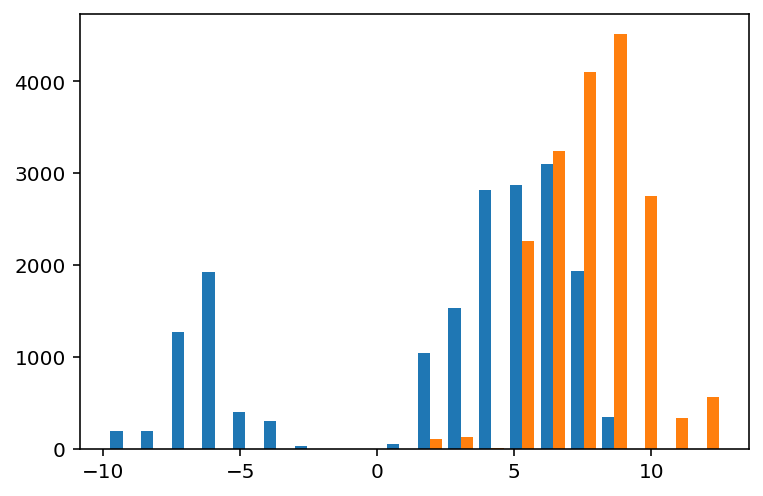

In [6]:
plt.hist(proj, bins=20);

In [7]:
threshold = proj[:, 0] > 0

res.groupby(threshold)['Q15'].value_counts(dropna=False)

       Q15                      
False  NaN                          2378
       I have never written code     865
       < 1 years                     386
       1-2 years                     285
       3-5 years                     197
       5-10 years                     99
       10-20 years                    60
       20+ years                      49
True   1-2 years                    3776
       < 1 years                    3442
       3-5 years                    3168
       5-10 years                   1788
       10-20 years                   985
       20+ years                     527
Name: Q15, dtype: int64

In [13]:
df, res = df[threshold].reset_index(drop=True), res[threshold].reset_index(drop=True)
df.shape, res.shape

((13686, 231), (13686, 218))

In [2]:
df.to_feather('data/encoded_subset.feather')
res.to_feather('data/processed_subset.feather')

NameError: name 'df' is not defined

In [33]:
df = pd.read_feather('data/encoded_subset.feather')
res = pd.read_feather('data/processed_subset.feather')

with open('data/responses.json', 'r') as f:
    uniques = json.load(f)
    
qs = pd.read_csv('data/questions_only.csv').T.squeeze()

## Selecting the number of clusters

There are a few important considerations when selecting the number of clusters:
* Most humans will struggle to keep track of more than about 7 or 8 user segments. Since the overall purpose of this analysis is to better understand our users, we will need to communicate our results to business leaders: slides will be drawn, presentations will be given, and reports will be written. Limiting ourselves to a few segments will help us draw a clearer picture of the user-base, especially when getting started.
* When doing the analysis, it is easy to overcluster (pick more clusters than what we expect the right number is), and then manually merge similar clusters together. Going in the opposite direction is much harder. 

Keeping these issues in mind, we will use the `Adjusted Rand Score` to measure the agreement between Q5 (job role) and the cluster labels (for the users) as we vary the number of clusters. We will use the agreement between Q5 and the cluster labels as a rough guide when selecting the cluster numbers, and not as a gold standard. If you are familiar with the adjusted rand score, feel free to skip ahead.

There are a number of cluster evaluation metrics that do not require ground truth labels, such as the `silhouette` coefficient and the `Calinski-Harabasz` index. Personally, I have not found them particularly useful, especially since each tends to favor a particular type of clustering. If you have successfully used any of these metrics, let me know in the comments! 

### Rand Index

The Adjusted Rand Score is based on the Rand Index, so we need to understand the latter first. The Rand Index is a standard measure of the similarity of two partitions of a dataset. Let's suppose we have the following partitions:

In [101]:
from itertools import combinations

In [102]:
p1 = [0, 0, 0, 1, 1, 1, 2, 2, 2]
p2 = [0, 1, 0, 1, 1, 1, 2, 0, 2]

The Rand Index is calculated by looking at all pairs of items and finding:
* `a` = number of pairs that are in the **same partition** in `p1` and also the in **the same partition** in `p2`.
* `b` = number of pairs that are in **different partitions** in `p1` and also in **different partitions** in `p2`.

The following functions do this calculation.

In [106]:
def same_subset(items, part):
    """Given a pair of items, find out if they are in the same partition"""
    i, j = items
    return part[i] == part[j]

def set_pairs(part, same=True):
    """Given a partition, find the set of pairs that are in the 
    same (same=True) or different (same=False) partitions"""
    if same:
        selection = lambda pair: same_subset(pair, part)
    else:
        selection = lambda pair: not same_subset(pair, part)
    n = len(part)
    return set(filter(selection, combinations(range(n), 2)))

For example, these are the set of pairs that are in the same partition in `p1`:

In [107]:
set_pairs(p1, same=True)

{(0, 1), (0, 2), (1, 2), (3, 4), (3, 5), (4, 5), (6, 7), (6, 8), (7, 8)}

Once we can find the appropriate pairs, we can easily calculate the Rand Index. It is simply given by:

$$RI = \frac{a + b}{n_{pairs}} = \frac{2 (a + b)}{n (n - 1)}$$

where $n$ is the total number of items in our dataset.

In [112]:
def rand_index(p1, p2):
    """Compute the Rand index (not adjusted)"""
    assert len(p1) == len(p2) and len(p1) > 2
    a = len(set_pairs(p1, True) & set_pairs(p2, True))
    b = len(set_pairs(p1, False) & set_pairs(p2, False))
    n_pairs = len(p1) * (len(p1) - 1) / 2
    return (a + b) / n_pairs

rand_index(p1, p2)

0.75

So this metric varies between 0 and 1, where 1 indicates a perfect agreement between the two partitions. An important property is that the Rand index is independent of the actual cluster labels:

In [117]:
p3 = [7, 7, 7, 8, 8, 8, 9, 9, 9]
rand_index(p3, p2)

0.75

### Adjusted Rand Score

One of the issues with the Rand index is that it is not adjusted for chance. For example, we can take a look at random partitions of the same length as `p1` and `p2`, and with the same number of segments (3), and measure the Rand index between these.

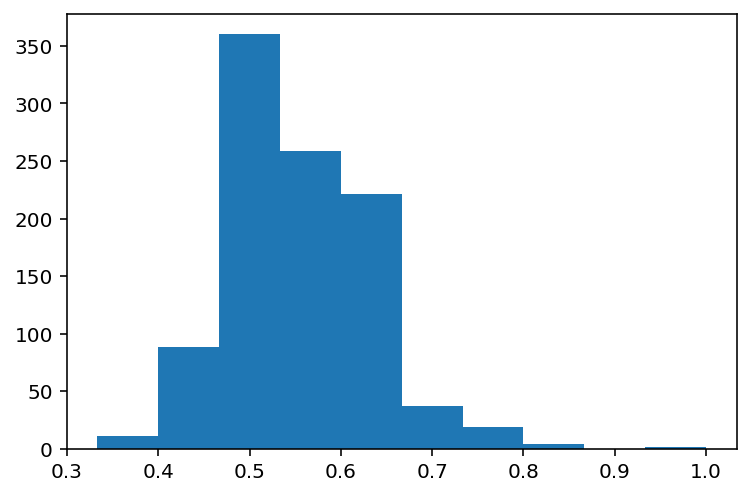

In [129]:
def rand_sample(u1, u2, part_len, n_iter):
    """Measures the Rand index between random sequences n_iter times.
    The two sequences have u1 and u2 unique elements, and are both of len = part_len."""
    scores = np.zeros(n_iter)
    for i in range(n_iter):
        s1 = np.random.choice(u1, part_len)
        s2 = np.random.choice(u2, part_len)
        scores[i] = rand_index(s1, s2)
    return scores

scores = rand_sample(3, 3, part_len=9, n_iter=1000)
plt.hist(scores, bins=10);

We can see that values between 0.4 and 0.7 are quite common when dealing with such a short sequence. We can try the same with longer sequences, and this is what we obtain:

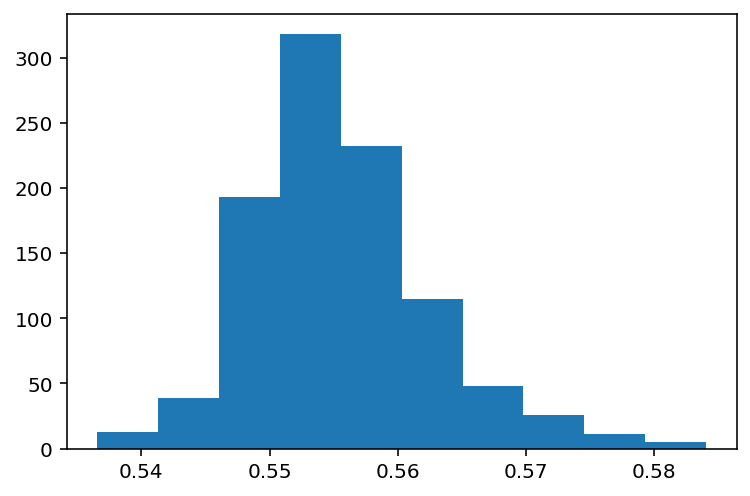

In [130]:
scores_long = rand_sample(3, 3, part_len=100, n_iter=1000)
plt.hist(scores_long, bins=10);

The score for the longer sequences is quite sharply peaked between 0.54 and 0.58, so it will be very unlikely to obtain a value of 0.75 by chance. 

The adjusted Rand index then takes this random variation into account as follows:

$$ARI = \frac{RI - E_{random}[RI]}{Max[RI] - E_{random}[RI]}$$

$ARI$ is simply a rescaled version of $RI$, computed by subtracting the mean $RI$ we would obtain by chance with random sequences (e.g. $E_{random}[RI] = 0.55$ for the example above), and by dividing this value by the difference between the maximum and the average $RI$. The division is done to increase the sensitivity of the metric. Note, this means that $ARI$ might be negative, if $RI < E_{random}[RI]$.

$ARI$ can be calculated exactly using the contingency table calculated from the two partitions. The formula can be found [here](https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index), and it is used by the `scikit-learn` implementation. 

However, I find it easier to understand the $ARI$ correction using the `rand_sample` we saw above. This will give us an approximation, and it will be slower to compute since we need to sample many times to simulate the $RI$ distribution. On the other hand, we can clearly see the link between the code below and the $ARI$ definition:

In [187]:
def adjusted_rand(p1, p2, n_iter=5000):
    u1, u2 = len(np.unique(p1)), len(np.unique(p2))
    mean_rand = np.mean(rand_sample(u1, u2, len(p1), n_iter))
    ri = rand_index(p1, p2)
    return (ri - mean_rand) / (1 - mean_rand)

In the above code, I have used the simplification $Max[RI] = 1$. This would not work if the two sequences have different number of clusters.

In [197]:
adjusted_rand(p1, p2)

0.438622754491018

Note that the $ARI$ is substantially lower for our short sequences compared with the $RI = 0.75$. We can also calculate it on longer sequences and compare against the scikit-learn implementation.

In [201]:
p4, p5 = np.random.choice(3, 100), np.random.choice(3, 100)
p4[:50] = p5[:50]  # some overlap between the sequences

adjusted_rand(p4, p5, 1000)

0.21344424178478605

In [202]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(p4, p5)

0.22032319946248075

The values are off by about 0.005, quite close!

## Back to survey results

We are now ready to do some clustering! We will fit SpectralCoclustering model using a range of clusters, and keep track of `ARI`.

In [203]:
def cocluster_iter(range_cl, data, **kwargs):
    """Fit SpectralCoclustering on a range of clusters"""
    for n_clusters in tqdm(range_cl):
        bicl = SpectralCoclustering(n_clusters=n_clusters, **kwargs)
        bicl.fit(data)
        yield n_clusters, bicl
        
def cluster_metrics(cocluster, metric, target):
    """Compute a given metric for a range of different n_clusters
    
    cocluster: coclustering generator that yields a fitted cluster object
    metric: metric callable
    target: target variable against which to compute metrics.
    """
    metrics = defaultdict(list)
    for n_clusters, bicl in cocluster:
        metrics['metric'].append(metric(bicl.row_labels_, target))
        metrics['n_clusters'].append(n_clusters)
    return pd.Series(metrics['metric'], index=metrics['n_clusters'])

In [215]:
cocluster = cocluster_iter(range(2, 25), df, random_state=0)
metrics = cluster_metrics(cocluster, adjusted_rand_score, res['Q5'].cat.codes)

100%|██████████| 23/23 [00:53<00:00,  2.33s/it]


Text(0.5, 1.0, 'Cluster metric against Q5 (Occupation)')

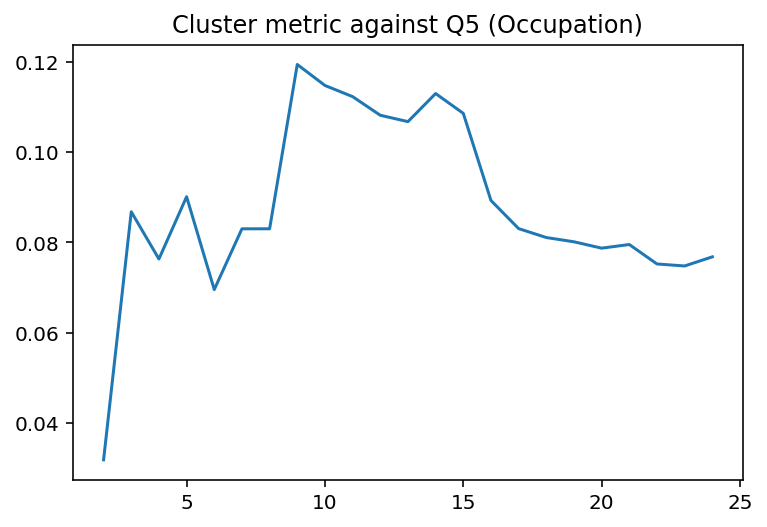

In [216]:
ax = metrics.plot()
ax.set_title('Cluster metric against Q5 (Occupation)')

There is a sudden spike at `n_clusters=9`, so we will use that as a starting point.

In [4]:
%%time

bicl = SpectralCoclustering(n_clusters=9, random_state=0)
bicl.fit(df)

print('Column (question) cluster counts:', np.unique(bicl.column_labels_, return_counts=True)[1])
print('Row (user) cluster counts:', np.unique(bicl.row_labels_, return_counts=True)[1])

Column (question) cluster counts: [31 30 11  9 11  6 35 28 70]
Row (user) cluster counts: [1914 2611 1113  856  565  123 2703 2330 1471]
CPU times: user 10.2 s, sys: 3.28 s, total: 13.5 s
Wall time: 1.76 s


Next, we are going to sort our data matrix according to the cluster labels.

In [5]:
row_idx, col_idx = np.argsort(bicl.row_labels_), np.argsort(bicl.column_labels_)
df_sorted = df.iloc[row_idx, col_idx]
rows_sorted = bicl.row_labels_[row_idx]
cols_sorted = bicl.column_labels_[col_idx]

In [31]:
def selector(cluster):
    avgs = df_sorted.groupby(rows_sorted == cluster).mean()
    deltas = avgs.loc[True] - avgs.loc[False]
    cluster_cols = deltas.loc[cols_sorted == cluster].sort_values(ascending=False)
    other_cols = deltas.loc[cols_sorted != cluster].sort_values(ascending=False)
    return cluster_cols, other_cols

def print_scores(scores, uniques):
    for q_label, score in scores.iteritems():
        q = q_label.split('_')[0]
        print(q, qs.loc[q][:50], ':', uniques[q_label][:25], round(score, 3))
    print()

def print_high(scores1, scores2, uniques, thr=0.1, high=10):
    print_scores(scores1[scores1 > thr], uniques)
    print('**other**')
    print_scores(scores2[scores2 > thr], uniques)

In [10]:
row_labels = pd.Series(bicl.row_labels_, index=df.index, name='cluster')
analysis = pd.concat([res[['Q4', 'Q5', 'Q6', 'Q7', 'Q15']], row_labels], axis=1)
analysis.head(2)

Q4                 Q5                    Q6   Q7        Q15  \
0  Master’s degree  Software Engineer  1000-9,999 employees    0  1-2 years   
1  Master’s degree              Other    > 10,000 employees  20+  1-2 years   

   cluster  
0        6  
1        8

First, we show the relationship between `Q5` and the clusters. We will use `altair` for the plotting, because it allows us to easily add interactive elements such as tooltips to our plots. Here is a bar chart of the distribution of job roles for each cluster. Since the cluster numbers are arbitrary, we sort the bars based on proportion of students, since clusters with large number of students should behave differently than those with few or no students. You can hover over the individual bars to get the actual user counts.

In [13]:
sort_order = (analysis
              .groupby('cluster')['Q5']
              .apply(lambda s: (s == 'Student').mean())
              .sort_values())

alt.Chart(data=analysis[['Q5', 'cluster']], width=500).mark_bar(size=35).encode(
    x=alt.X('cluster:N', sort=sort_order.index.tolist()),
    y=alt.Y('count()', stack='normalize', title='Proportion (per cluster)'),
    color=alt.Color('Q5', scale=alt.Scale(scheme='tableau20')),
    tooltip=['Q5', 'count()']
)

alt.Chart(...)

In [20]:
# def stacked_bar(data, q):
#     return alt.Chart(data=data, width=350, height=200).mark_bar(size=25).encode(
#         x=alt.X('cluster:N', sort=sort_order.index.tolist()),
#         y=alt.Y('count()', title='Proportion (per cluster)', stack='normalize'),
#         color=alt.Color(f'{q}:O', scale=alt.Scale(scheme='inferno')),
#         tooltip=[q, 'count()']
#     )

# stacked_bar(analysis, 'Q15')

In [ ]:
x = pd.DataFrame()

In [35]:
for cluster in range(bicl.n_clusters):
    print(cluster, (row_labels == cluster).sum())
    print_high(*selector(cluster), uniques, thr=0.15)

0 1914
Q24 Which of the following ML algorithms do you use on : Convolutional Neural Netw 0.574
Q26 Which categories of computer vision methods do you : Image classification and  0.447
Q21 Which types of specialized hardware do you use on  : GPUs 0.398
Q28 Which of the following machine learning frameworks :  Keras  0.359
Q17 Which of the following hosted notebook products do :  Google Colab  0.352
Q28 Which of the following machine learning frameworks :   TensorFlow  0.334
Q24 Which of the following ML algorithms do you use on : Dense Neural Networks (ML 0.312
Q26 Which categories of computer vision methods do you : Image segmentation method 0.306
Q26 Which categories of computer vision methods do you : General purpose image/vid 0.305
Q24 Which of the following ML algorithms do you use on : Recurrent Neural Networks 0.287
Q28 Which of the following machine learning frameworks :  PyTorch  0.279
Q26 Which categories of computer vision methods do you : Object detection methods  0.262
Q18

In [62]:
[uniques[k] for k in uniques if 'Q9' in k]

['Analyze and understand data to influence product or business decisions',
 'Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data',
 'Build prototypes to explore applying machine learning to new areas',
 'Build and/or run a machine learning service that operationally improves my product or workflows',
 'Experimentation and iteration to improve existing ML models',
 'Do research that advances the state of the art of machine learning',
 'None of these activities are an important part of my role at work',
 'Other']

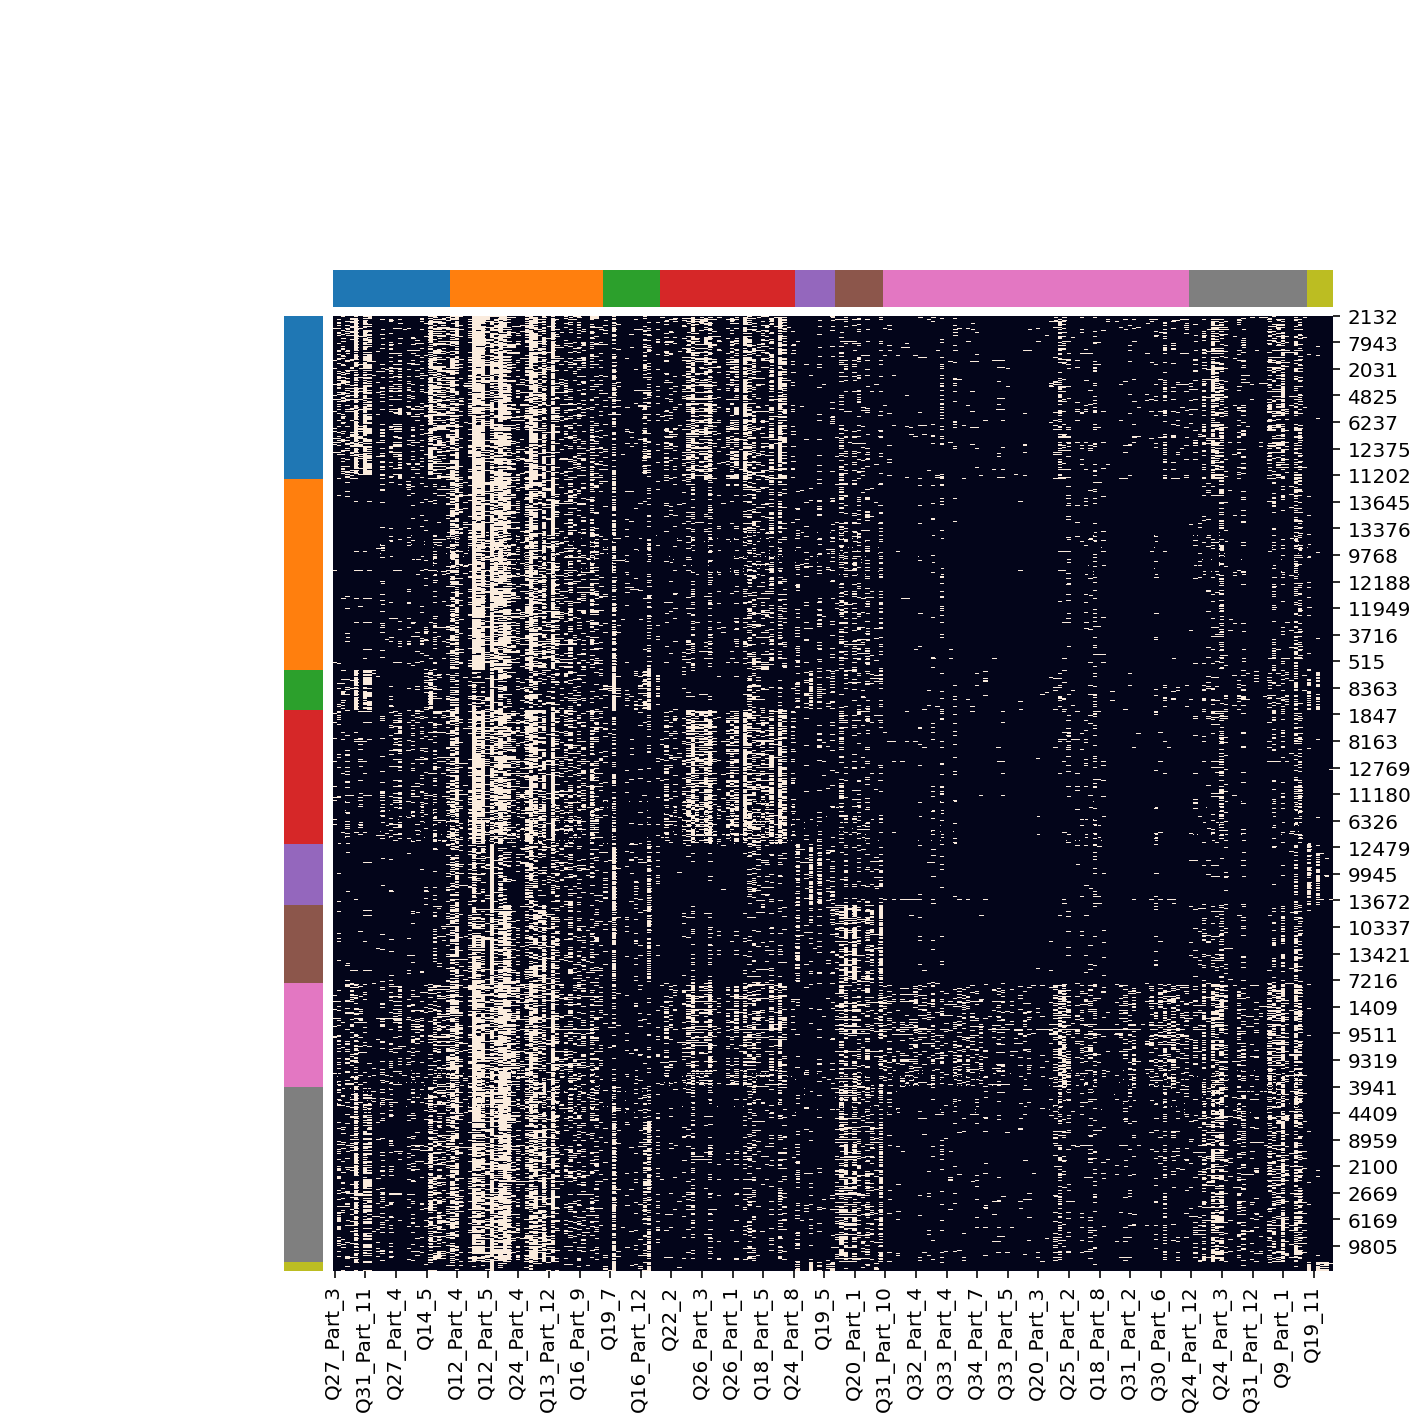

In [63]:
sns.clustermap(df_sorted, row_cluster=False, col_cluster=False, 
               row_colors=[pal[i] for i in rows_sorted],
               col_colors=[pal[i] for i in cols_sorted], 
               cbar_pos=None)

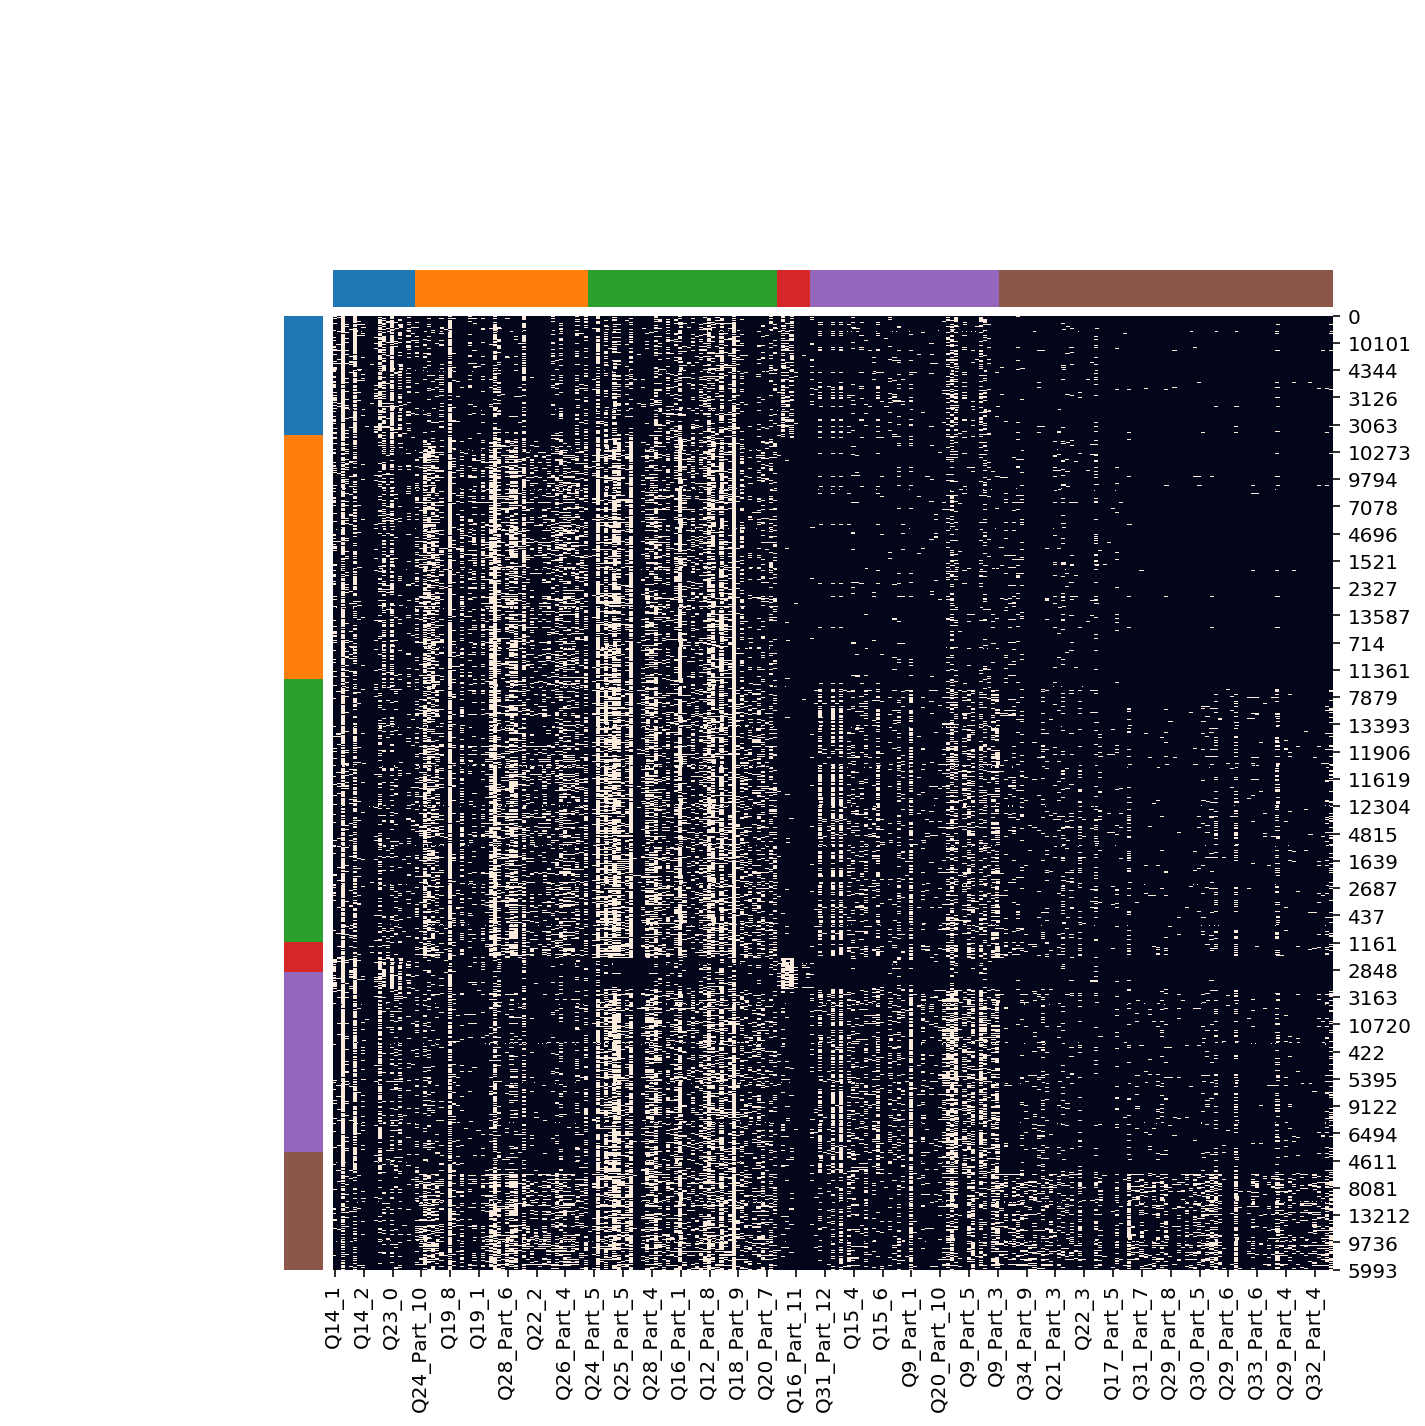

In [14]:
sns.clustermap(df_sorted, row_cluster=False, col_cluster=False, 
               row_colors=[pal[i] for i in rows_sorted],
               col_colors=[pal[i] for i in cols_sorted],
               cbar_pos=None)

In [309]:
raw['Q12_Part_6']

0                                                    NaN
1                                                    NaN
2        YouTube (Cloud AI Adventures, Siraj Raval, etc)
3        YouTube (Cloud AI Adventures, Siraj Raval, etc)
4        YouTube (Cloud AI Adventures, Siraj Raval, etc)
                              ...                       
13681    YouTube (Cloud AI Adventures, Siraj Raval, etc)
13682                                                NaN
13683    YouTube (Cloud AI Adventures, Siraj Raval, etc)
13684                                                NaN
13685                                                NaN
Name: Q12_Part_6, Length: 13686, dtype: object

In [286]:
df.columns[bicl.column_labels_ == 0]

Index(['Q9_Part_1', 'Q9_Part_2', 'Q9_Part_3', 'Q9_Part_4', 'Q9_Part_5',
       'Q9_Part_6', 'Q9_Part_8', 'Q12_Part_2', 'Q12_Part_7', 'Q12_Part_9',
       ...
       'Q15_4', 'Q15_5', 'Q15_6', 'Q19_0', 'Q23_2', 'Q23_3', 'Q23_4', 'Q23_5',
       'Q23_6', 'Q23_7'],
      dtype='object', length=133)

In [282]:
raw['Q21_Part_1'].value_counts()

CPUs    10167
Name: Q21_Part_1, dtype: int64

### Try spectral biclustering and print selected features!

In [231]:
%%time

# spect = SpectralClustering(n_clusters=4, affinity='cosine').fit(df_sample)
prop = AffinityPropagation(affinity='precomputed', damping=0.9, random_state=0, verbose=1).fit(clst.affinity_matrix_)

Did not converge
CPU times: user 4min 36s, sys: 1.11 s, total: 4min 37s
Wall time: 4min 37s


/home/nikolay/.pyenv/versions/3.7.4/envs/main/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:244: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


In [233]:
prop.cluster_centers_indices_

[]

In [234]:
prop.affinity

'precomputed'

In [46]:
clst.affinity_matrix_.max()

1.0000000000000022

In [57]:
%%time

mapper = UMAP(n_neighbors=30, min_dist=0.1, metric='cosine', random_state=0, n_components=4)
proj = mapper.fit_transform(df_sample)

CPU times: user 37.1 s, sys: 1.4 s, total: 38.5 s
Wall time: 36.6 s


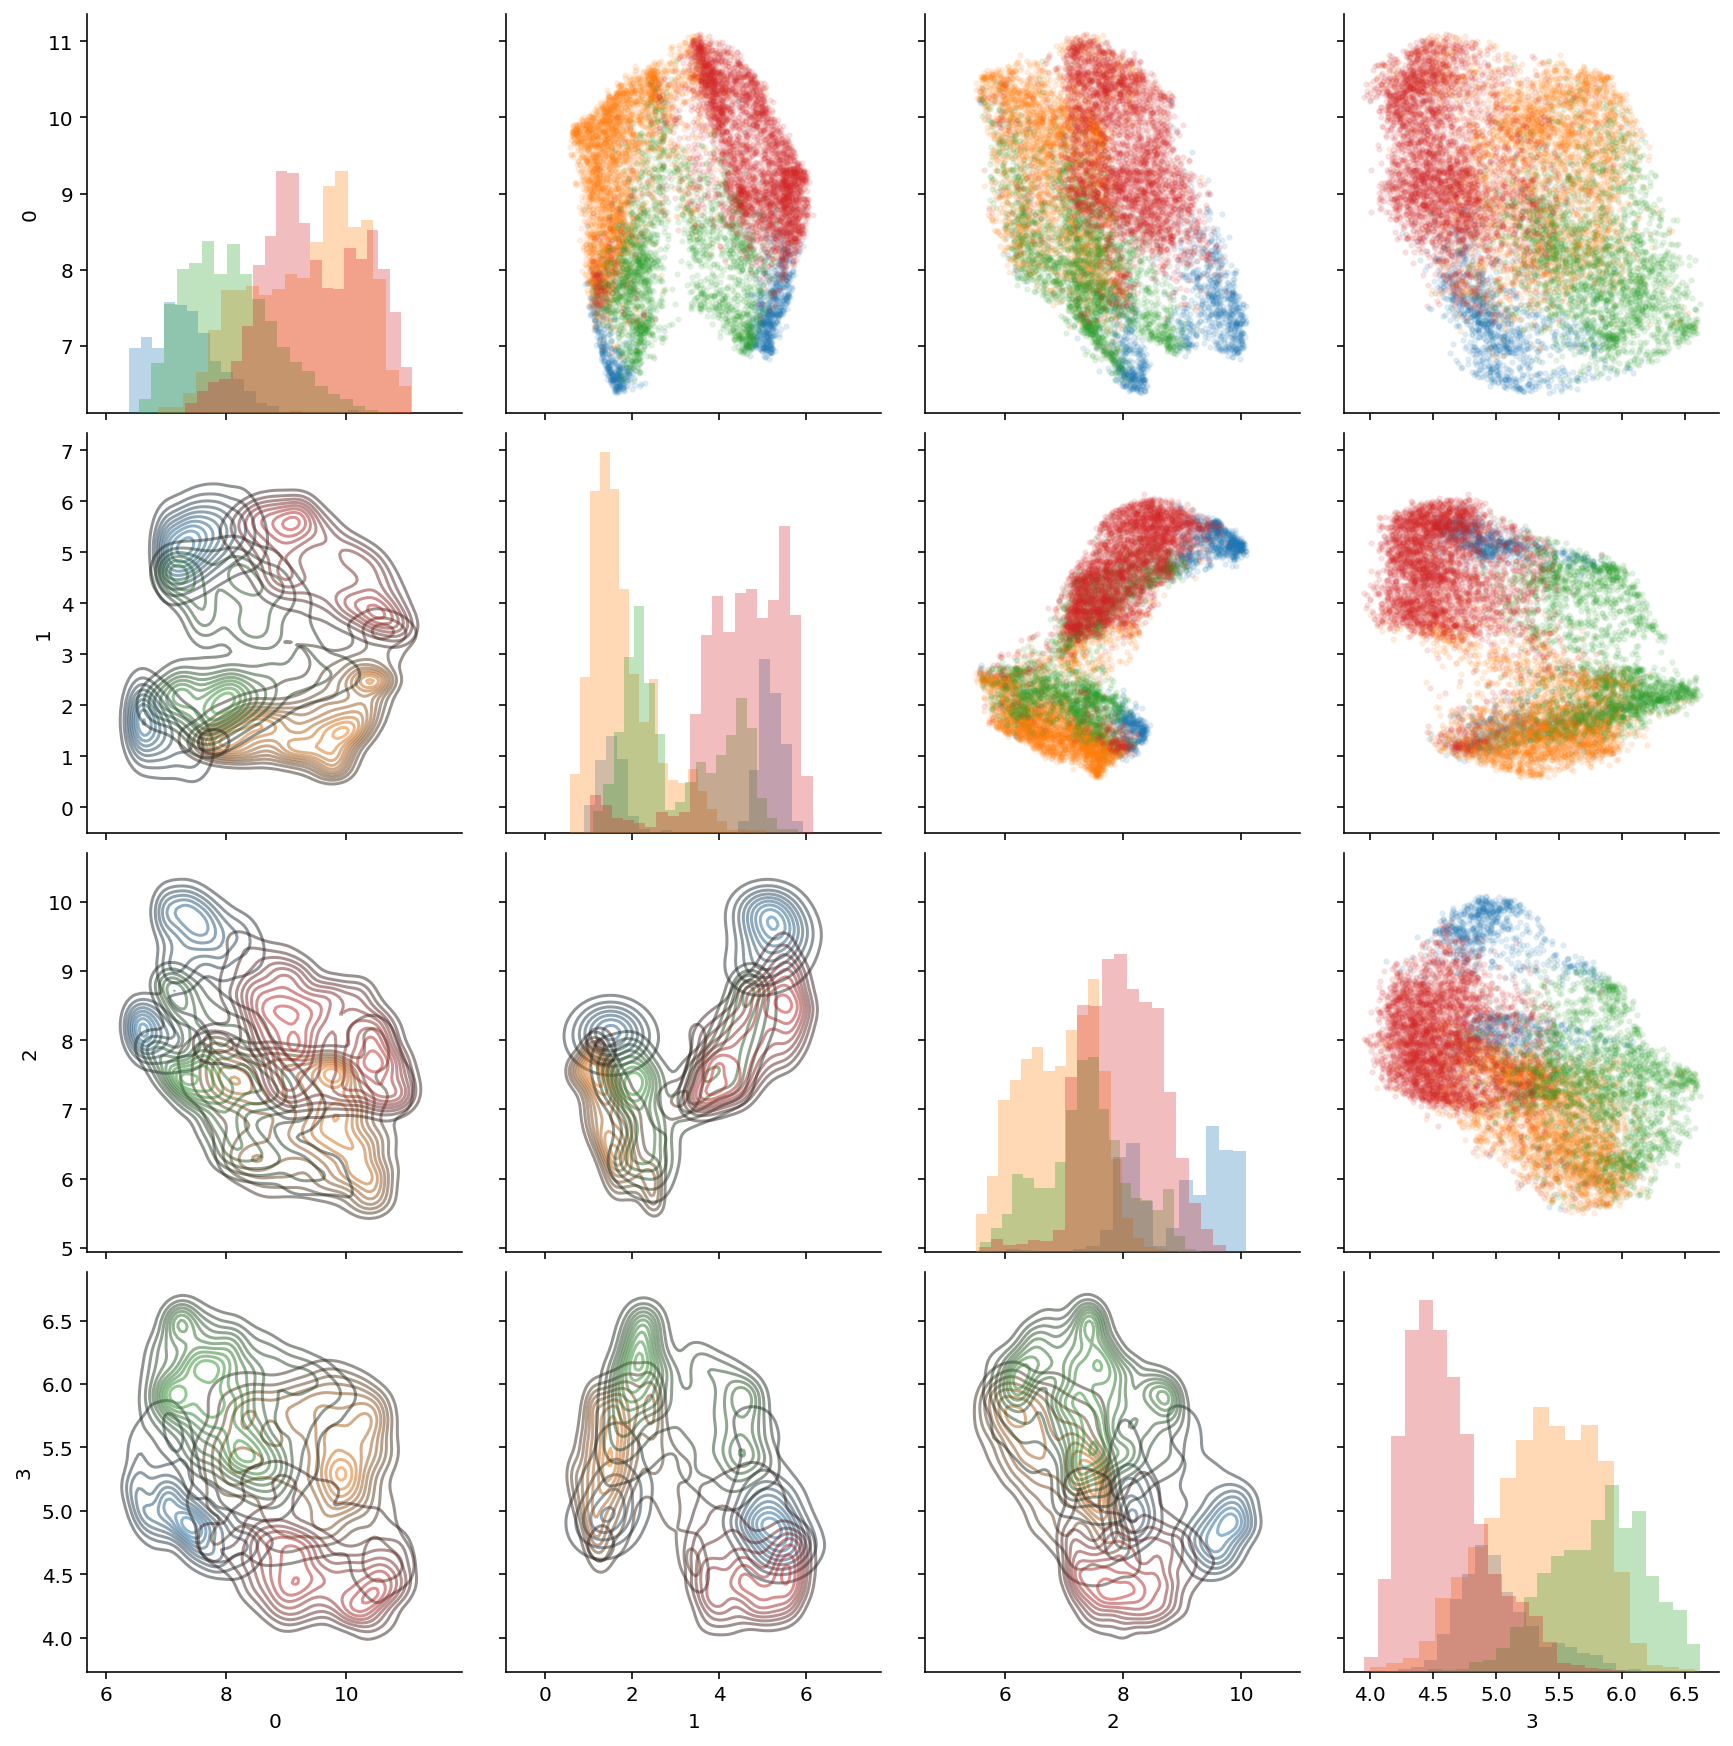

In [88]:
g = (sns.PairGrid(pd.DataFrame(proj).assign(label=clst.labels_), hue='label', height=3)
     .map_upper(plt.scatter, alpha=0.1, s=5)
     .map_lower(sns.kdeplot, alpha=0.5)
     .map_diag(plt.hist, bins=20, alpha=0.3))

In [99]:
from sklearn.decomposition import FactorAnalysis, PCA

In [177]:
pca = PCA(n_components=50).fit(df_sample)

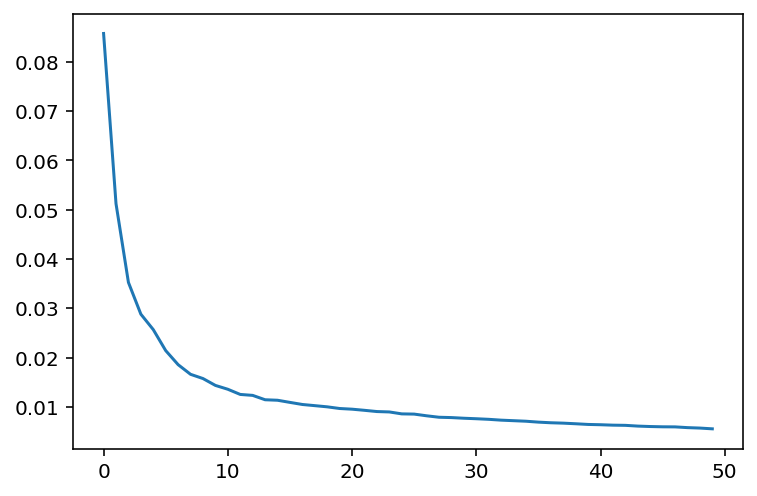

In [129]:
plt.plot(pca.explained_variance_ratio_)

In [175]:
pd.DataFrame(pca.components_, columns=df_sample.columns).loc[0].sort_values().tail(10)

Q28_Part_5    0.148395
Q9_Part_3     0.151779
Q24_Part_9    0.155029
Q26_Part_4    0.156727
Q28_Part_1    0.163255
Q24_Part_3    0.177566
Q28_Part_2    0.182224
Q21_Part_2    0.198031
Q28_Part_3    0.198835
Q24_Part_7    0.200463
Name: 0, dtype: float64

In [169]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [179]:
lda = LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen').fit(df_sample, clst.labels_)

In [180]:
lda_proj = lda.transform(df_sample)

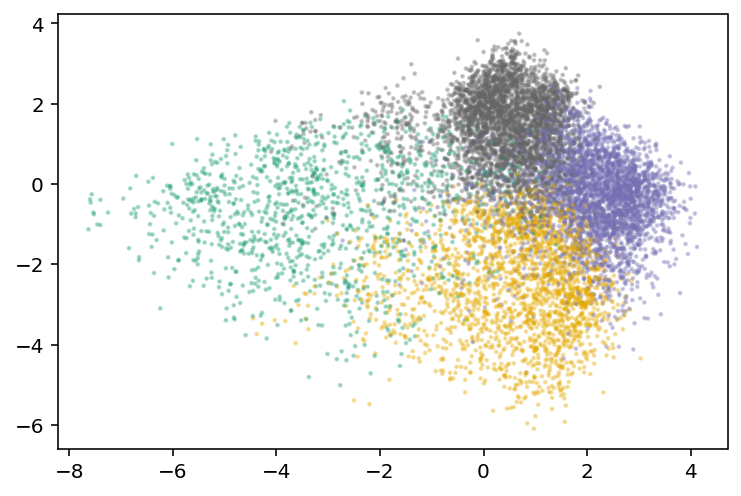

In [201]:
plt.scatter(lda_proj[:, 0], lda_proj[:, 1], alpha=0.3, s=2, c=clst.labels_, cmap='Dark2')

In [208]:
coefs = pd.DataFrame(lda.coef_.T, index=df_sample.columns)

In [212]:
raw.head(2)

Time from Start to Finish (seconds)     Q1    Q2         Q3  \
0                                  510  22-24  Male     France   
1                                  391  40-44  Male  Australia   

                Q4                 Q5                    Q6   Q7  \
0  Master’s degree  Software Engineer  1000-9,999 employees    0   
1  Master’s degree              Other    > 10,000 employees  20+   

              Q8 Q9_Part_1  ... Q34_Part_3 Q34_Part_4 Q34_Part_5 Q34_Part_6  \
0  I do not know       NaN  ...        NaN        NaN        NaN        NaN   
1  I do not know       NaN  ...        NaN        NaN        NaN        NaN   

  Q34_Part_7 Q34_Part_8          Q34_Part_9 Q34_Part_10 Q34_Part_11  \
0        NaN        NaN                 NaN         NaN         NaN   
1        NaN        NaN  Azure SQL Database         NaN         NaN   

  Q34_Part_12  
0         NaN  
1         NaN  

[2 rows x 218 columns]

In [214]:
coefs[0].sort_values().tail(10)

Q19_7    15.228946
Q19_9    16.204586
Q19_1    16.637810
Q19_8    16.897798
Q19_3    17.067240
Q19_0    18.195133
Q22_3    18.499834
Q22_2    18.708038
Q22_1    19.276687
Q22_0    23.590901
Name: 0, dtype: float64

In [217]:
sorted(raw['Q19'].value_counts().index)

['Bash',
 'C',
 'C++',
 'Java',
 'Javascript',
 'MATLAB',
 'None',
 'Other',
 'Python',
 'R',
 'SQL',
 'TypeScript']

/home/nikolay/.pyenv/versions/3.7.4/envs/main/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


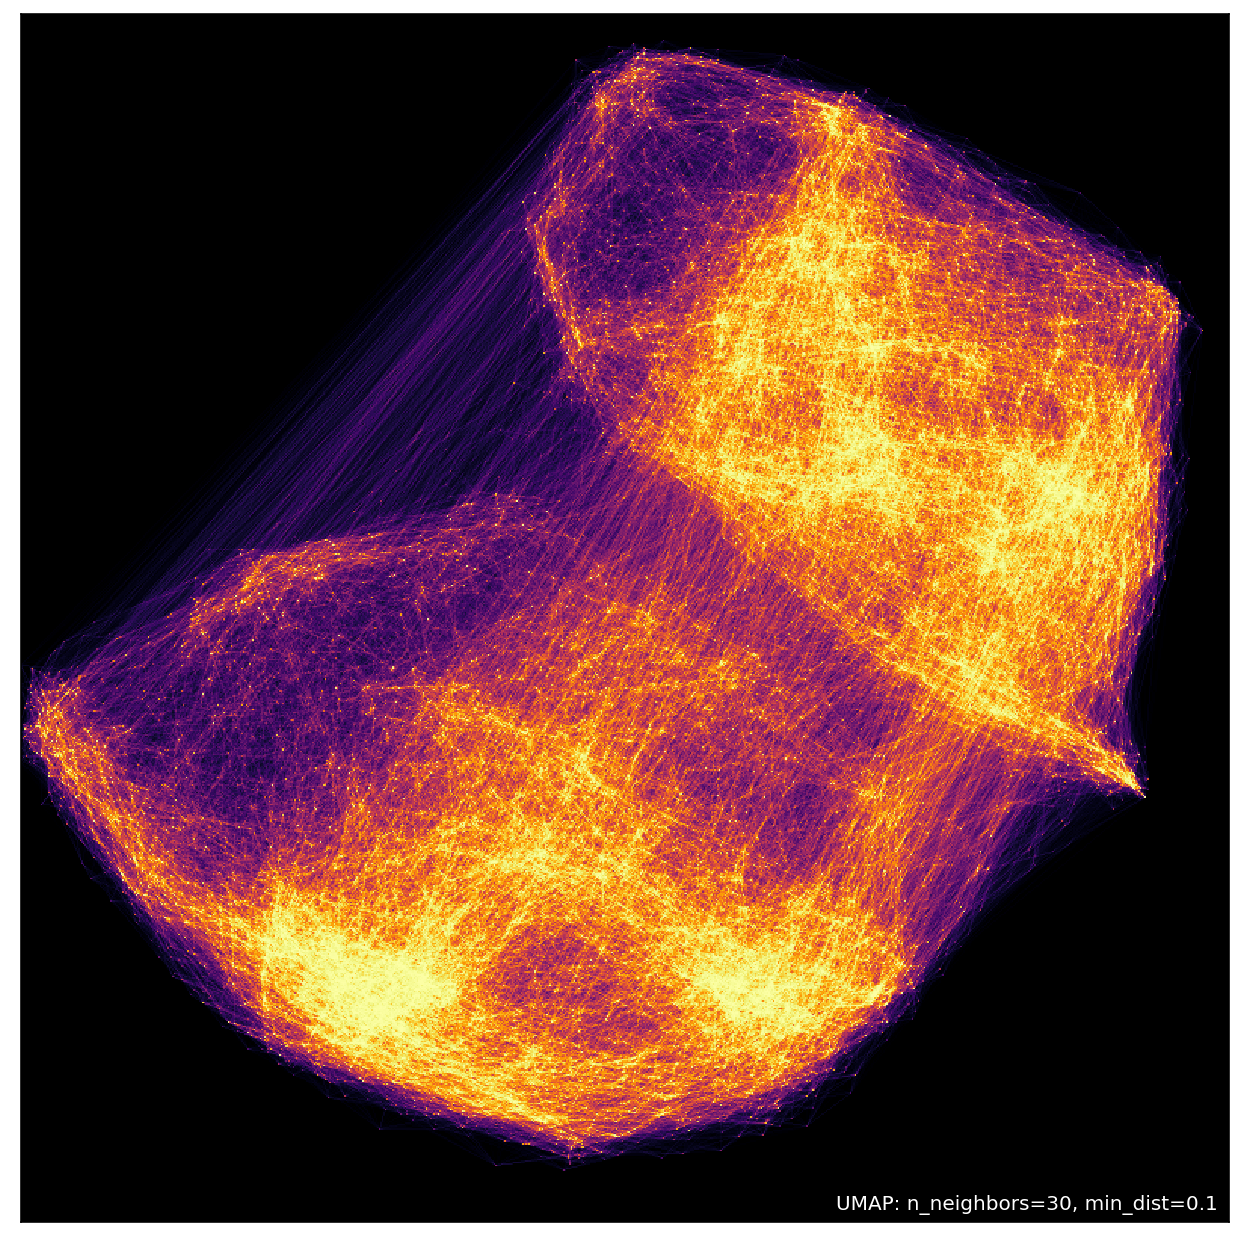

In [26]:
umap.plot.connectivity(mapper, edge_cmap='inferno', background='black')

In [2]:
sample = df.sample(5000, random_state=0)

NameError: name 'df' is not defined

In [17]:
mapper_subset = UMAP(n_neighbors=30, min_dist=0.1, metric='cosine').fit(df.sample(8000, random_state=0))
umap.plot.connectivity(mapper_subset, edge_bundling='hammer')

/home/nikolay/.pyenv/versions/3.7.4/envs/main/lib/python3.7/site-packages/umap/plot.py:850: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  "Hammer edge bundling is expensive for large graphs!\n"


KeyboardInterrupt: 

/home/nikolay/.pyenv/versions/3.7.4/envs/main/lib/python3.7/site-packages/umap/plot.py:850: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  "Hammer edge bundling is expensive for large graphs!\n"


KeyboardInterrupt: 